In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#loaing M4 cluster 
m4_df = pd.read_fwf('../data/NGC6121-1.dat', names=['source_id', 'ra', 'dec', 'phot_g_mean_mag', 'parallax', 'radial_velocity'])

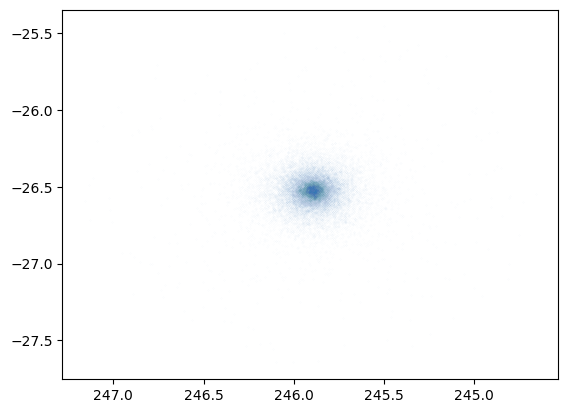

In [3]:
plt.scatter(m4_df.ra, m4_df.dec, s=0.0001)
plt.gca().invert_xaxis()

In [4]:
#M4 cluster using Gaia's measurements of stars' locations on the sky
#3 degree x 3 degree box centered at `RA=246, dec=-26.5`
df = pd.read_csv('../data/m4_gaia_source.csv')

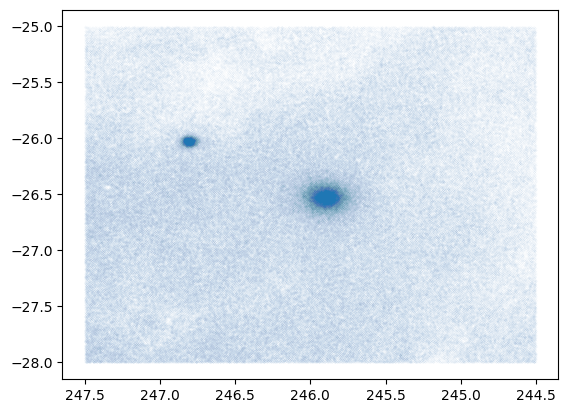

In [5]:
plt.scatter(df.ra, df.dec, s=0.0001)
plt.gca().invert_xaxis()

In [6]:
#classifying cluster members only from Gaia
m4_sel = df['source_id'].isin(m4_df.source_id)
print(np.count_nonzero(m4_sel))

19084


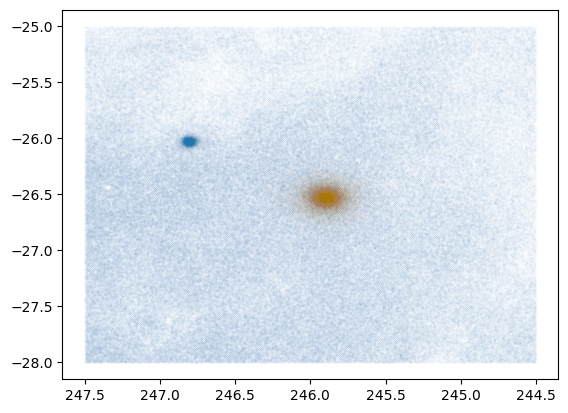

In [7]:
plt.scatter(df.ra[~m4_sel], df.dec[~m4_sel], s=0.0001)
plt.scatter(df.ra[m4_sel], df.dec[m4_sel], s=0.0001)
plt.gca().invert_xaxis()

In [8]:
#location right ascension and declination
params = ['ra', 'dec', 'parallax', 'radial_velocity']
X = np.array(df[params])
X.shape

(494996, 4)

Be sure to use the data model documentation to understand what each feature is, and explain why you think it would be useful for identifying cluster members. 

Answer: I am adding parallax and radial velocity of stars as M4 members has to have similar distance and motion relative to earth. On the other hand non member might have significantly different value.

In [9]:
np.count_nonzero(np.any(np.isnan(X), axis=1)) #checking for missing values

487748

In [10]:
#when we start adding more columns we might miss values
# If there _were_ missing values, we would remove them like so
nans = np.any(np.isnan(X), axis=1)
X = X[~nans]

n_classes = 10
y = m4_sel.astype(int)[~nans] 

In [11]:
#normalizing input feature/ standarizing with mean 0

from sklearn.preprocessing import StandardScaler
transformer = StandardScaler()

X = transformer.fit_transform(X)

In [12]:
#using 10% data for testing and rest of them for training
m = X.shape[0]
test_frac = 0.1
test_sel = np.random.choice([True, False], size=m, p=[test_frac, 1-test_frac])
X_tst = X[test_sel]
X_train = X[~test_sel]

y_tst = y[test_sel]
y_train = y[~test_sel]

In [13]:
#balancing member and non-member 

In [14]:
X_m4 = X_train[y_train == 1]
X_non_m4 = X_train[y_train == 0]
y_m4 = y_train[y_train == 1]
y_non_m4 = y_train[y_train == 0]

In [15]:
from sklearn.utils import resample

In [16]:
#reducing number of non members M4
X_non_m4_resampled, y_non_m4_resampled = resample(X_non_m4, y_non_m4, 
                                                  n_samples=X_m4.shape[0],  # Match size of M4 members
                                                  random_state=42)

In [17]:
# Combine the resampled non-members with the M4 members
X_balanced = np.vstack([X_m4, X_non_m4_resampled])
y_balanced = np.hstack([y_m4, y_non_m4_resampled])

In [18]:
X_train = X_balanced
y_train = y_balanced

In [19]:
sum(y_train)

374

In [20]:
len(y_train)-sum(y_train)

374

In [21]:
import jax
import jax.numpy as jnp

In [22]:
X_train = jnp.array(X_train)
X_tst = jnp.array(X_tst)
y_train = jnp.array(y_train)
y_tst = jnp.array(y_tst)

In [23]:
#neural network design
batch_size = 64
n_batches = X_train.shape[0] // batch_size

X_train = X_train[:n_batches * batch_size].reshape((n_batches, batch_size, *X_train.shape[1:]))
y_train = y_train[:n_batches * batch_size].reshape((n_batches, batch_size, *y_train.shape[1:]))
X_train.shape, y_train.shape

((11, 64, 4), (11, 64))

In [24]:
from flax import linen as nn

In [25]:
#model training
n_classes = 10

class DenseClassifier(nn.Module):
    """A simple dense classifier."""

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(n_classes)(x)
        return x

In [26]:
#summary of the model
dummy_input = jnp.ones((1, 4))
dnn = DenseClassifier()
print(dnn.tabulate(jax.random.PRNGKey(0), dummy_input))


                            DenseClassifier Summary                             
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module          ┃ inputs        ┃ outputs       ┃ params           ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│         │ DenseClassifier │ float32[1,4]  │ float32[1,10] │                  │
├─────────┼─────────────────┼───────────────┼───────────────┼──────────────────┤
│ Dense_0 │ Dense           │ float32[1,4]  │ float32[1,10] │ bias:            │
│         │                 │               │               │ float32[10]      │
│         │                 │               │               │ kernel:          │
│         │                 │               │               │ float32[4,10]    │
│         │                 │               │               │                  │
│         │                 │               │               │ 50 (200 B)       │
├─────────┼────────────────

In [27]:
X_train.shape, y_train.shape

((11, 64, 4), (11, 64))

In [28]:
from clu import metrics
from flax.training import train_state
from flax import struct
import optax

In [29]:
#we have 270 trainable parameter
#Training

@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
   metrics: Metrics

In [30]:
def create_train_state(model, rng, learning_rate):
    params = model.init(rng, dummy_input)['params']
    tx = optax.adam(learning_rate)
    return TrainState.create(
        apply_fn=model.apply, params=params, tx=tx,
        metrics=Metrics.empty())

In [31]:
@jax.jit
def train_step(state, batch, label):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

In [32]:
@jax.jit
def compute_metrics(*, state, batch, label):
    logits = state.apply_fn({'params': state.params}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=label, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [33]:
init_rng = jax.random.PRNGKey(0)

learning_rate = 0.01

state = create_train_state(dnn, init_rng, learning_rate)
del init_rng  # Must not be used anymore.

In [34]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [35]:
n_epochs = 50

In [36]:
step = 0

for _ in range(n_epochs):
  for batch, label in zip(X_train, y_train):

    # Run optimization steps over training batches and compute batch metrics
    state = train_step(state, batch, label) # get updated train state (which contains the updated parameters)
    state = compute_metrics(state=state, batch=batch, label=label) # aggregate batch metrics

    if (step+1) % n_batches == 0: # one training epoch has passed
      for metric,value in state.metrics.compute().items(): # compute metrics
        metrics_history[f'train_{metric}'].append(value) # record metrics
      state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

      # Compute metrics on the test set after each training epoch
      test_state = state
      test_state = compute_metrics(state=test_state, batch=X_tst, label=y_tst)

      for metric,value in test_state.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)

      print(f"train epoch: {(step+1) // n_batches}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
      print(f"test epoch: {(step+1) // n_batches}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")
    step += 1

train epoch: 1, loss: 2.2055630683898926, accuracy: 45.3125
test epoch: 1, loss: 2.347224235534668, accuracy: 13.407821655273438
train epoch: 2, loss: 1.4433536529541016, accuracy: 72.44318389892578
test epoch: 2, loss: 1.7509918212890625, accuracy: 51.25698471069336
train epoch: 3, loss: 0.861691415309906, accuracy: 79.40340423583984
test epoch: 3, loss: 1.295401930809021, accuracy: 62.01116943359375
train epoch: 4, loss: 0.5149940252304077, accuracy: 84.94318389892578
test epoch: 4, loss: 0.8380268812179565, accuracy: 70.81005859375
train epoch: 5, loss: 0.36801907420158386, accuracy: 87.78409576416016
test epoch: 5, loss: 0.5499825477600098, accuracy: 79.18994140625
train epoch: 6, loss: 0.3147203028202057, accuracy: 90.625
test epoch: 6, loss: 0.4439582824707031, accuracy: 82.68156433105469
train epoch: 7, loss: 0.25121769309043884, accuracy: 93.32386016845703
test epoch: 7, loss: 0.3622826039791107, accuracy: 89.80447387695312
train epoch: 8, loss: 0.19978009164333344, accuracy: 9

In [37]:
import matplotlib.pyplot as plt

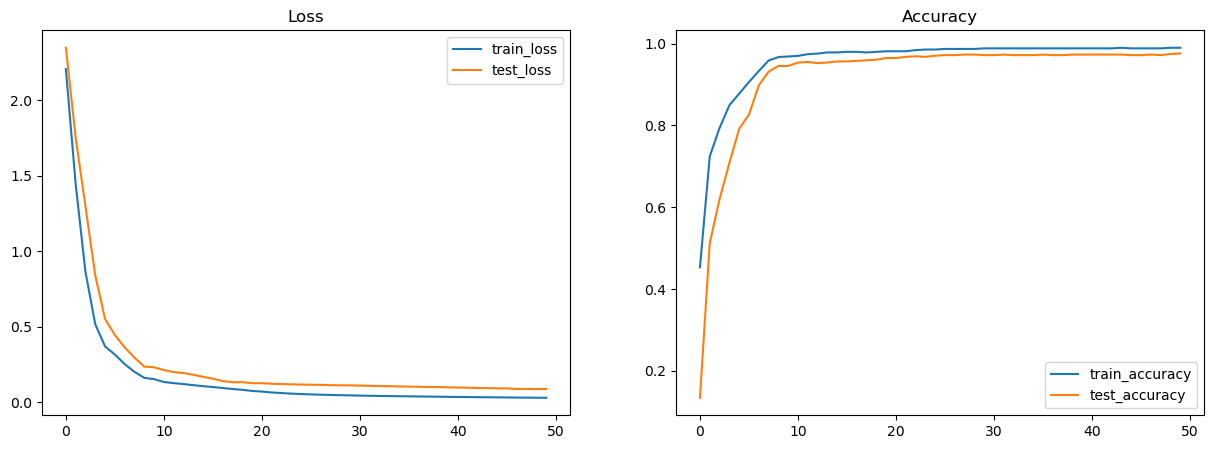

<Figure size 640x480 with 0 Axes>

In [38]:
# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

What training and validation accuracies can you achieve?

Answer: I am surprised to see 100% accuracy and following validation graph but I have less number of y_train so its not impossible to get this result as well. 

In [39]:
#checking classifier
@jax.jit
def pred_step(state, batch):
  logits = state.apply_fn({'params': state.params}, batch)
  return logits.argmax(axis=1)

pred = pred_step(state, X_tst)
pred

Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,

(array([659.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  57.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

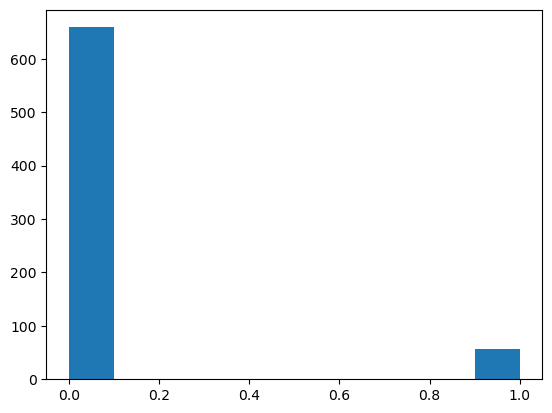

In [40]:
plt.hist(pred)

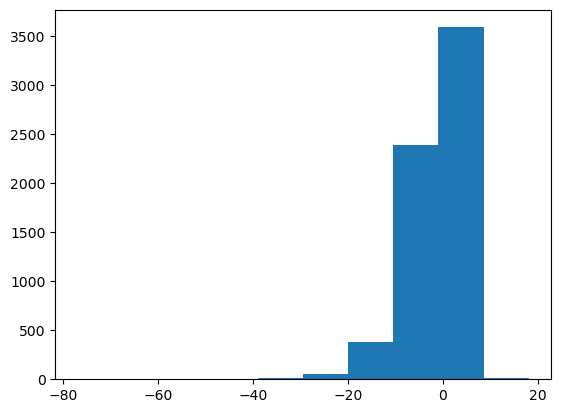

In [41]:
#difference (remember these are "log"its) of the values from the output nodes to see 
# if it's picking up hints of something useful
outputs = state.apply_fn({'params': state.params}, X_tst)
plt.hist(jnp.diff(outputs, axis=1).flatten());

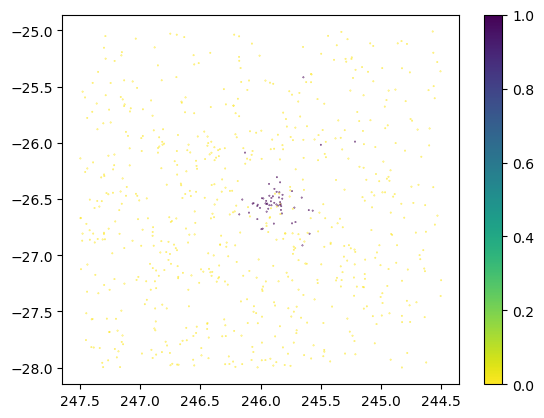

In [42]:
# Scatter plot: Right Ascension (RA) vs Declination (Dec)
plt.scatter(
    df.ra[~nans][test_sel],   # Right Ascension (x-axis)
    df.dec[~nans][test_sel],  # Declination (y-axis)
    c=jnp.argmax(outputs, axis=1),      # Color by predicted class (from classifier)
    s=0.1,                    # Size of points
    cmap='viridis_r'          # Color map for class visualization
)

plt.colorbar()
plt.gca().invert_xaxis()
plt.show()


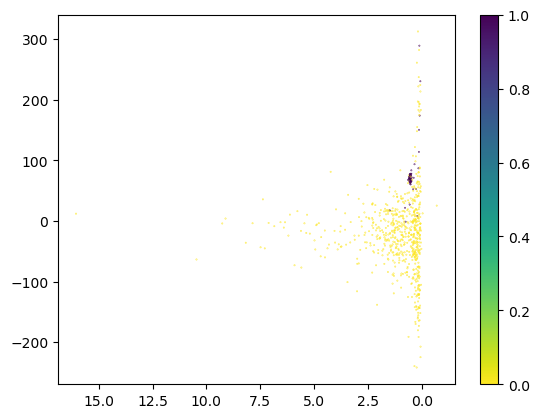

In [43]:
# Scatter plot: parallax and radial_velocity
plt.scatter(df.parallax[~nans][test_sel], df.radial_velocity[~nans][test_sel], c=jnp.argmax(outputs, axis=1), s=.1, cmap='viridis_r')

plt.colorbar()
plt.gca().invert_xaxis()
plt.show()

Does your trained model find any stars it believes are confidently in M4 that weren't in the M4 catalog?

Answer: Our trained model could see similar values on some of the non members similar to members stars. Yes I can see my trained model confidently recognized some stars as members of M4 but they were not.

<function matplotlib.pyplot.show(close=None, block=None)>

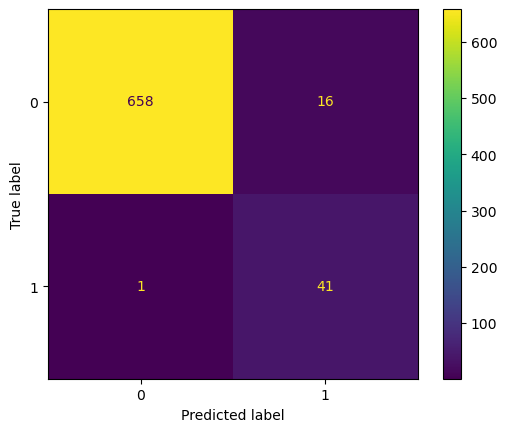

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

M = confusion_matrix(y_tst, pred)

Visualization = ConfusionMatrixDisplay(confusion_matrix=M)
Visualization.plot()
plt.show